In [1]:
import os
import sys
root_dir = os.path.abspath('../')
sys.path.append(root_dir)

import seaborn as sns
import matplotlib.pyplot as plt

# --- Stunning palette: Viridis or Plasma ---
palette = sns.color_palette("viridis", 8)

sns.set_theme(
    style="whitegrid",
    font="sans-serif",
    rc={
        "font.size": 13,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "semibold",
        "axes.edgecolor": "#2F2F2F",
        "axes.linewidth": 0.8,
        "grid.color": "#CCCCCC",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "figure.facecolor": "#FAFAFA",
        "axes.facecolor": "#FFFFFF",
        "axes.prop_cycle": plt.cycler("color", palette),
    }
)

### Goal

We would like to model

$x_{i,t}=\Lambda f_t + \epsilon_{i,t}$

* $i$ = patient index
* $t$ = time (irregular visits per patient)
* $x_{i,t} \in R^p$ Patients embedding information (realization from the latent factor)
* $f_t \in R^r$ Shared latent temporatl factors (underlying population health states)
* $\Lambda \in R^{p\times r}$ Factor loadings (relationship between embeddings and latent factors)

### Mapping

| Model Element | Interpretation |
|---------------|----------------|
| Observed variables | Daily metrics (Counts by department, age group, diagnosis group) |
| Latent factors | Underlying patient-type intensities that jointly influence those metrics |
| Factor loadings | How strongly each variable with each latent patient type |
| Factor dynamics | How those patient types evolve over time (trends, cycles, shocks) |

In [27]:
import pandas as pd

# Dynamic Factor Model - engineered data
dfm_data = pd.read_parquet(
    os.path.join(root_dir, "data/processed/hana_ent/dfm_daily.parquet")
)
full_range = pd.date_range(dfm_data.index.min(), dfm_data.index.max(), freq='D')
dfm_data = dfm_data.reindex(full_range)
dfm_data = dfm_data.fillna(0)

# Resample to weekly frequency
dfm_data = dfm_data.resample('W').sum()

# Supply data
supply = pd.read_parquet(
    os.path.join(root_dir, "./data/processed/hana_ent/supply.parquet")
)
full_range = pd.date_range(supply.index.min(), supply.index.max(), freq='D')
supply = supply.reindex(full_range)
supply = supply.fillna(0)

# Resample to weekly frequency
supply = supply.resample('W').sum()

# Major supply: dexamethasone, tramadol, netilmicin, electrolytes with carbohydrates, diclofenac
supply_major = supply[['dexamethasone', 'tramadol', 'netilmicin', 'electrolytes with carbohydrates', 'diclofenac']]

In [28]:
dfm_data.head(2)

,male,female,age_0_10,age_10_20,age_20_30,age_30_40,age_40_50,age_50_60,age_60_70,age_70_80,...,M01,M03,N01,N02,N05,N07,R03,R05,R06,V03
2018-01-07,1703.0,1512.0,105.0,46.0,656.0,899.0,707.0,406.0,208.0,86.0,...,78.0,0.0,46.0,1047.0,0.0,0.0,0.0,6.0,25.0,0.0
2018-01-14,1660.0,1498.0,95.0,54.0,687.0,1030.0,651.0,349.0,188.0,88.0,...,121.0,0.0,44.0,882.0,0.0,0.0,0.0,2.0,29.0,0.0


In [29]:
supply_major.head(2)

prescription,dexamethasone,tramadol,netilmicin,electrolytes with carbohydrates,diclofenac
2018-01-07,1414.0,1047.0,336.0,107.0,78.0
2018-01-14,1348.0,882.0,501.0,85.0,121.0


In [30]:
import numpy as np
import pandas as pd

def prepare_dfm_window(X: pd.DataFrame, min_var: float = 1e-8) -> pd.DataFrame:
    """
    Per-window preprocessing for DynamicFactor:
    - Drop constant / near-constant columns
    - Standardize (z-score)
    """
    # Drop columns with almost no variance
    var = X.var()
    keep_cols = var[var > min_var].index
    X = X[keep_cols]

    # Standardize
    X = (X - X.mean()) / X.std(ddof=0)

    # Remove columns that became NaN (zero std)
    X = X.dropna(axis=1)

    return X

In [45]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from pydantic import BaseModel, Field
from typing import List, Literal
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR


class DFMConfig(BaseModel):
    n_factors: int = Field(..., description="Number of latent factors")
    factor_order: int = Field(1, description="Factor VAR order (for VAR, not DFM)")


class RegressionConfig(BaseModel):
    target_columns: List[str] = Field(..., description="Supply usage columns")


class RollingConfig(BaseModel):
    window_type: Literal["rolling", "expanding"] = Field(..., description="Window mode")
    window_size: int = Field(..., description="Number of time points per rolling window")
    forecast_horizon: int = Field(..., description="Steps ahead")
    min_train_size: int = Field(50, description="Minimum size for first window")


def fit_dfm(X: pd.DataFrame, cfg: DFMConfig):
    """
    Fit DynamicFactor on standardized weekly data.
    Returns factors as a pandas DataFrame with shape (T_window, n_factors).
    """

    model = DynamicFactor(
        X,
        k_factors=cfg.n_factors,
        factor_order=1,
        error_cov_type="scalar"
    )

    result = model.fit(disp=False)

    raw = result.factors.filtered  # may be ndarray or DataFrame
    T = len(X)
    k = cfg.n_factors

    # --- Case 1: ndarray ---
    if isinstance(raw, np.ndarray):

        # Shape may be (T, k) or (k, T)
        if raw.shape == (T, k):
            data = raw
        elif raw.shape == (k, T):
            data = raw.T
        else:
            raise ValueError(f"Unexpected factor shape: {raw.shape}")

        factor_df = pd.DataFrame(
            data,
            index=X.index,
            columns=[f"F{i+1}" for i in range(k)]
        )
        return factor_df, result

    # --- Case 2: DataFrame ---
    if isinstance(raw, pd.DataFrame):
        # Ensure correct orientation
        if raw.shape == (T, k):
            factor_df = raw.copy()
            factor_df.index = X.index
            factor_df.columns = [f"F{i+1}" for i in range(k)]
            return factor_df, result

        if raw.shape == (k, T):
            factor_df = raw.T.copy()
            factor_df.index = X.index
            factor_df.columns = [f"F{i+1}" for i in range(k)]
            return factor_df, result

        raise ValueError(f"Unexpected DataFrame factor shape: {raw.shape}")

    # Should not reach here
    raise ValueError("Unrecognized factor result type.")

In [46]:
def fit_supply_models(factors: pd.DataFrame,
                      supply_df: pd.DataFrame,
                      reg_cfg: RegressionConfig):
    models = {}
    X = factors.values
    for col in reg_cfg.target_columns:
        y = supply_df[col].loc[factors.index]
        model = LinearRegression()
        model.fit(X, y)
        models[col] = model
    return models


def forecast_factors_var(factors: pd.DataFrame,
                         steps: int,
                         lags: int) -> pd.DataFrame:
    """
    Forecast factors via VAR. This is the 'dynamic' part of method 1.1.
    """
    var_model = VAR(factors)
    var_res = var_model.fit(maxlags=lags)

    fc_values = var_res.forecast(y=factors.values[-lags:], steps=steps)

    freq = factors.index.inferred_freq or "W"
    start = factors.index[-1] + pd.tseries.frequencies.to_offset(freq)
    idx = pd.date_range(start, periods=steps, freq=freq)

    return pd.DataFrame(fc_values, index=idx, columns=factors.columns)


def predict_supplies(factor_fc: pd.DataFrame,
                     models: dict,
                     reg_cfg: RegressionConfig) -> pd.DataFrame:
    Xf = factor_fc.values
    out = {}
    for col in reg_cfg.target_columns:
        out[col] = models[col].predict(Xf)
    return pd.DataFrame(out, index=factor_fc.index)

In [47]:
def rolling_method_11(
    dfm_data: pd.DataFrame,
    supply_data: pd.DataFrame,
    dfm_cfg: DFMConfig,
    reg_cfg: RegressionConfig,
    roll_cfg: RollingConfig
) -> pd.DataFrame:

    # Align on weekly index
    common_idx = dfm_data.index.intersection(supply_data.index)
    dfm_data = dfm_data.loc[common_idx]
    supply_data = supply_data.loc[common_idx]

    preds = []
    dates = dfm_data.index

    for end_idx in range(
        roll_cfg.min_train_size,
        len(dates) - roll_cfg.forecast_horizon + 1
    ):
        if roll_cfg.window_type == "rolling":
            start_idx = max(0, end_idx - roll_cfg.window_size)
        else:
            start_idx = 0

        window_dates = dates[start_idx:end_idx]
        Xw_raw = dfm_data.loc[window_dates]
        Sw = supply_data.loc[window_dates]

        # Per-window prep (this is the key change)
        Xw = prepare_dfm_window(Xw_raw)

        # If we ended up with too few columns or NaNs, skip this window
        if Xw.shape[1] < dfm_cfg.n_factors:
            continue
        if Xw.isna().any().any():
            continue
        if Sw.isna().any().any():
            continue

        try:
            # 1) DFM on weekly data
            factors, dfm_result = fit_dfm(Xw, dfm_cfg)

            # 2) Regression: supply ~ factors
            models = fit_supply_models(factors, Sw, reg_cfg)

            # 3) Forecast factors using VAR dynamics
            factor_fc = forecast_factors_var(
                factors=factors,
                steps=roll_cfg.forecast_horizon,
                lags=dfm_cfg.factor_order
            )

            # 4) Predict supplies
            supply_fc = predict_supplies(factor_fc, models, reg_cfg)

        except Exception as e:
            # If this still fails for some windows, we just skip them
            # You can print(e) here if you want to inspect.
            continue

        preds.append(supply_fc)

    if len(preds) == 0:
        raise ValueError("All windows failed even after standardization and column filtering.")

    predictions = pd.concat(preds).sort_index()
    predictions = predictions[~predictions.index.duplicated(keep="last")]

    return predictions


def rolling_method_11_fixed_10(
    dfm_data: pd.DataFrame,
    supply_data: pd.DataFrame,
    dfm_cfg: DFMConfig,
    reg_cfg: RegressionConfig,
    roll_cfg: RollingConfig,
    n_windows: int = 10
) -> pd.DataFrame:

    # Align indices
    common_idx = dfm_data.index.intersection(supply_data.index)
    dfm_data = dfm_data.loc[common_idx]
    supply_data = supply_data.loc[common_idx]

    preds = []
    dates = dfm_data.index

    # Select 10 evenly spaced window end-points
    possible_end = range(roll_cfg.min_train_size,
                         len(dates) - roll_cfg.forecast_horizon)

    ends = np.linspace(start=roll_cfg.min_train_size,
                       stop=len(dates) - roll_cfg.forecast_horizon - 1,
                       num=n_windows, dtype=int)

    for end_idx in ends:

        # Compute window positions
        if roll_cfg.window_type == "rolling":
            start_idx = max(0, end_idx - roll_cfg.window_size)
        else:
            start_idx = 0

        wdates = dates[start_idx:end_idx]
        Xw_raw = dfm_data.loc[wdates]
        Sw = supply_data.loc[wdates]

        # Prepare window
        Xw = prepare_dfm_window(Xw_raw)

        if Xw.shape[1] < dfm_cfg.n_factors:
            continue
        if Xw.isna().any().any() or Sw.isna().any().any():
            continue

        # Fit models
        factors, dfm_result = fit_dfm(Xw, dfm_cfg)
        models = fit_supply_models(factors, Sw, reg_cfg)
        factor_fc = forecast_factors_var(
            factors,
            steps=roll_cfg.forecast_horizon,
            lags=dfm_cfg.factor_order
        )
        supply_fc = predict_supplies(factor_fc, models, reg_cfg)

        preds.append(supply_fc)

    if len(preds) == 0:
        raise ValueError("All 10 fixed windows failed.")

    preds = pd.concat(preds).sort_index()
    preds = preds[~preds.index.duplicated(keep="last")]

    return preds

In [48]:
dfm_cfg = DFMConfig(
    n_factors=3,      # start small, you can tune this
    factor_order=1
)

reg_cfg = RegressionConfig(
    target_columns=[
        "dexamethasone",
        "tramadol",
        "netilmicin",
        "electrolytes with carbohydrates",
        "diclofenac",
    ]
)

roll_cfg = RollingConfig(
    window_type="rolling",
    window_size=104,      # for example: 2 years of weekly data
    forecast_horizon=4,   # 4 weeks ahead
    min_train_size=80     # first forecast after ~1.5 years
)

pred = rolling_method_11_fixed_10(
    dfm_data=dfm_data,
    supply_data=supply_major,
    dfm_cfg=dfm_cfg,
    reg_cfg=reg_cfg,
    roll_cfg=roll_cfg
)

/Users/goonzard/Developer/ds-202501-health-econ-mlflow/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/goonzard/Developer/ds-202501-health-econ-mlflow/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/goonzard/Developer/ds-202501-health-econ-mlflow/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/goonzard/Developer/ds-202501-health-econ-mlflow/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

In [50]:
def compare_pred_with_actual(
    pred: pd.DataFrame,
    supply_true: pd.DataFrame,
    target_cols: list
) -> pd.DataFrame:
    """
    Align predicted DataFrame with true supply values
    and compute error metrics.
    """

    # Extract true values for the prediction dates
    true_aligned = supply_true.loc[pred.index]

    comparisons = []

    for col in target_cols:
        df_col = pd.DataFrame({
            "pred": pred[col],
            "true": true_aligned[col]
        })
        df_col["error"] = df_col["pred"] - df_col["true"]
        df_col["abs_error"] = df_col["error"].abs()
        df_col["sq_error"] = df_col["error"] ** 2

        df_col.columns = pd.MultiIndex.from_product([[col], df_col.columns])
        comparisons.append(df_col)

    return pd.concat(comparisons, axis=1)


comparison = compare_pred_with_actual(
    pred=pred,
    supply_true=supply_major,
    target_cols=reg_cfg.target_columns
)

print(comparison)

           dexamethasone                                               \
                    pred   true       error   abs_error      sq_error   
2019-07-21    411.102337  319.0   92.102337   92.102337   8482.840426   
2019-07-28    422.074469  310.0  112.074469  112.074469  12560.686643   
2019-08-04    433.280973  280.0  153.280973  153.280973  23495.056760   
2019-08-11    444.157429  282.0  162.157429  162.157429  26295.031702   
2020-02-23    270.555908  214.0   56.555908   56.555908   3198.570683   
2020-03-01    249.435354   72.0  177.435354  177.435354  31483.304790   
2020-03-08    234.097655   74.0  160.097655  160.097655  25631.259189   
2020-03-15    223.177666   87.0  136.177666  136.177666  18544.356741   
2020-09-27    113.032082   94.0   19.032082   19.032082    362.220130   
2020-10-04    117.082650   61.0   56.082650   56.082650   3145.263669   
2020-10-11    120.944817   78.0   42.944817   42.944817   1844.257306   
2020-10-18    124.739168  177.0  -52.260832   52.26

In [ ]:
def prepare_comparison_with_integer_index(pred, supply_true, target_cols):
    """
    Returns:
        - comparison table (pred vs true)
        - integer index mapping DataFrame
    """

    # Align true values
    true_aligned = supply_true.loc[pred.index]

    # Reset the index → turn dates into a column
    df = pd.DataFrame({
        "date": pred.index,
    }).reset_index(drop=True)

    # integer index mapping: 0,1,2,... → actual date
    index_map = df.copy()
    index_map["int_index"] = index_map.index

    # Add predictions and true values
    for col in target_cols:
        df[f"{col}_pred"] = pred[col].values
        df[f"{col}_true"] = true_aligned[col].values

    return df, index_map

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_separate_graphs_better(
    comparison_df: pd.DataFrame,
    index_map: pd.DataFrame,
    target_cols: list
):
    """
    Draws 5 separate, easy-to-read graphs.
    X-axis = integer index
    Y-axis = predicted vs actual
    """

    # Distinct, highly contrasting colors
    pred_color = "#1f77b4"   # blue
    true_color = "#d62728"   # red

    for col in target_cols:

        pred_col = f"{col}_pred"
        true_col = f"{col}_true"

        plt.figure(figsize=(14, 4))

        # Plot actual values
        plt.plot(
            comparison_df.index,
            comparison_df[true_col],
            label="Actual",
            linewidth=2.6,
            color=true_color,
            marker="o",
            markersize=6
        )

        # Plot predicted values
        plt.plot(
            comparison_df.index,
            comparison_df[pred_col],
            label="Predicted",
            linewidth=2.6,
            color=pred_color,
            marker="s",
            markersize=6
        )

        plt.title(f"Predicted vs Actual – {col}", weight="bold", fontsize=16)
        plt.xlabel("Integer Index")
        plt.ylabel("Weekly Usage")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Print mapping after all plots
    print("\nInteger index → Actual date mapping:")
    print(index_map[["int_index", "date"]].to_string(index=False))

Integer index → Actual date mapping:
    int_index       date
0           0 2019-07-21
1           1 2019-07-28
2           2 2019-08-04
3           3 2019-08-11
4           4 2020-02-23
5           5 2020-03-01
6           6 2020-03-08
7           7 2020-03-15
8           8 2020-09-27
9           9 2020-10-04
10         10 2020-10-11
11         11 2020-10-18
12         12 2021-05-02
13         13 2021-05-09
14         14 2021-05-16
15         15 2021-05-23
16         16 2021-12-05
17         17 2021-12-12
18         18 2021-12-19
19         19 2021-12-26
20         20 2022-07-17
21         21 2022-07-24
22         22 2022-07-31
23         23 2022-08-07
24         24 2023-02-19
25         25 2023-02-26
26         26 2023-03-05
27         27 2023-03-12
28         28 2023-09-24
29         29 2023-10-01
30         30 2023-10-08
31         31 2023-10-15
32         32 2024-04-28
33         33 2024-05-05
34         34 2024-05-12
35         35 2024-05-19
36         36 2024-12-08
37         37

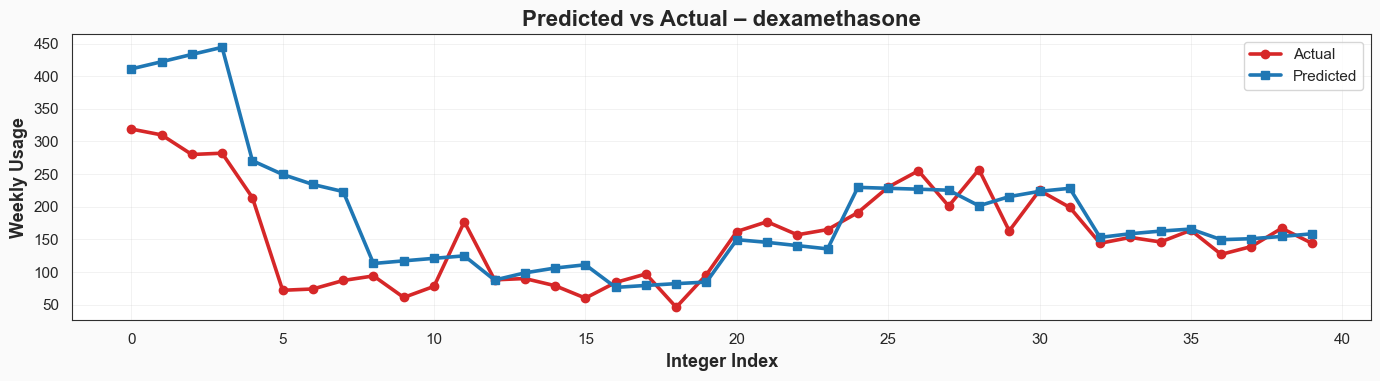

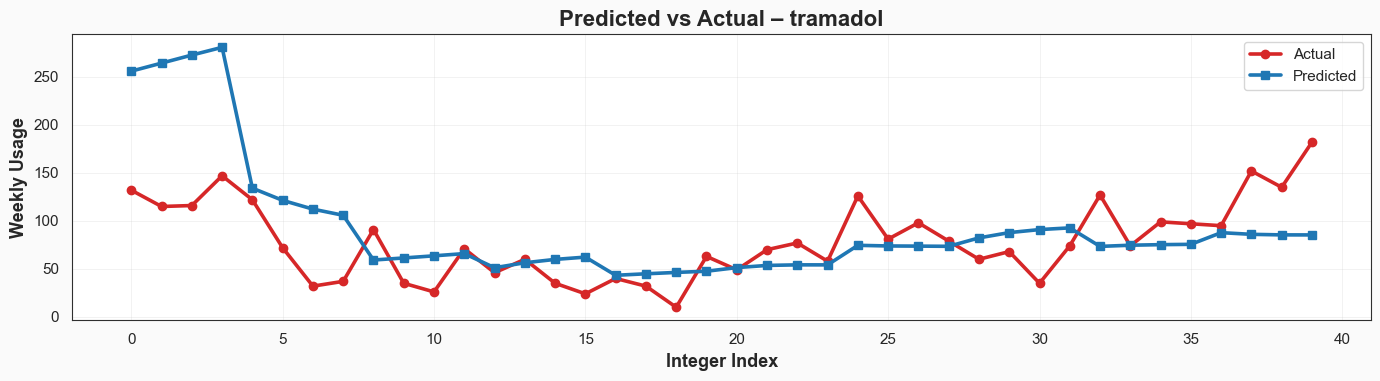

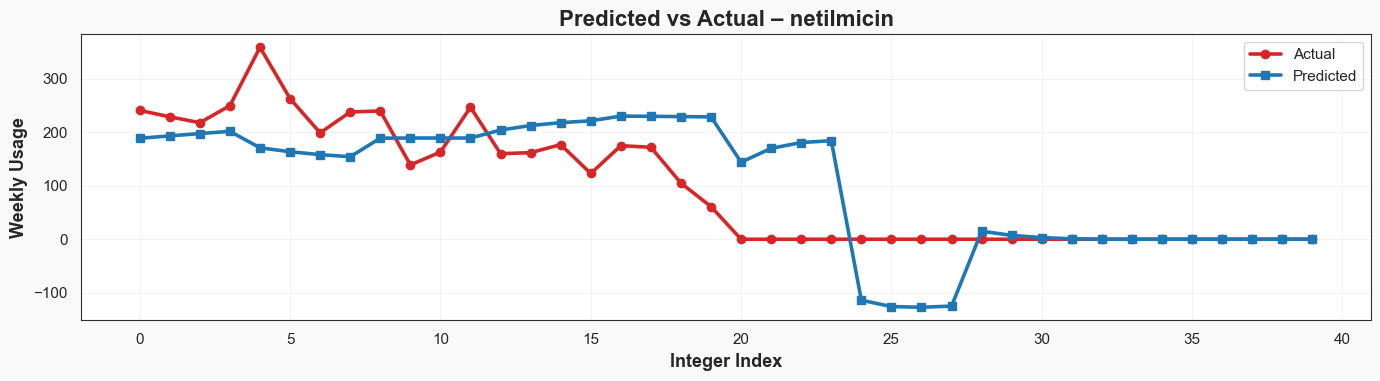

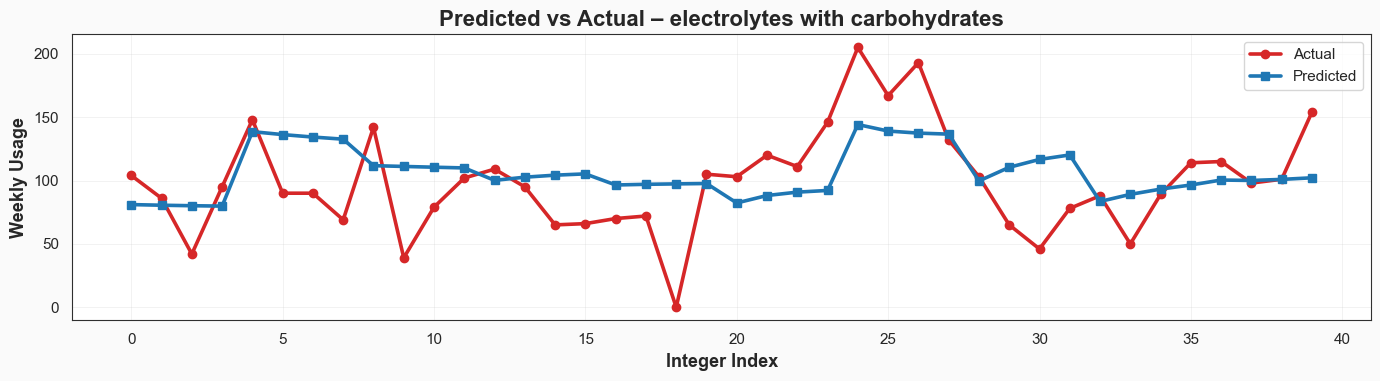

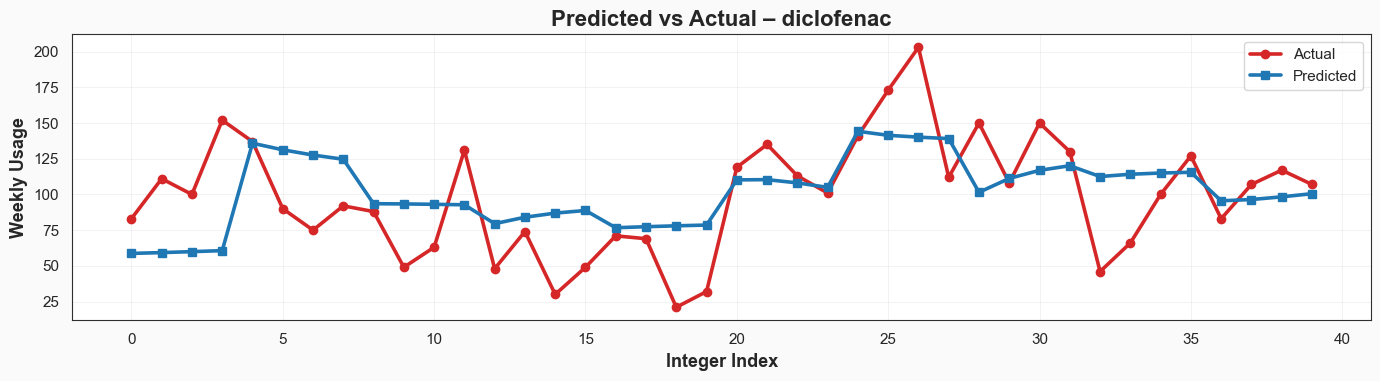


Integer index → Actual date mapping:
 int_index       date
         0 2019-07-21
         1 2019-07-28
         2 2019-08-04
         3 2019-08-11
         4 2020-02-23
         5 2020-03-01
         6 2020-03-08
         7 2020-03-15
         8 2020-09-27
         9 2020-10-04
        10 2020-10-11
        11 2020-10-18
        12 2021-05-02
        13 2021-05-09
        14 2021-05-16
        15 2021-05-23
        16 2021-12-05
        17 2021-12-12
        18 2021-12-19
        19 2021-12-26
        20 2022-07-17
        21 2022-07-24
        22 2022-07-31
        23 2022-08-07
        24 2023-02-19
        25 2023-02-26
        26 2023-03-05
        27 2023-03-12
        28 2023-09-24
        29 2023-10-01
        30 2023-10-08
        31 2023-10-15
        32 2024-04-28
        33 2024-05-05
        34 2024-05-12
        35 2024-05-19
        36 2024-12-08
        37 2024-12-15
        38 2024-12-22
        39 2024-12-29


In [59]:
comparison_df, index_map = prepare_comparison_with_integer_index(
    pred=pred,
    supply_true=supply_major,
    target_cols=reg_cfg.target_columns
)

print("Integer index → Actual date mapping:")
print(index_map[["int_index", "date"]])

plot_separate_graphs_better(
    comparison_df=comparison_df,
    index_map=index_map,
    target_cols=reg_cfg.target_columns
)

In [62]:
comparison_df.to_excel("comparison_df.xlsx")